<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Adapted from: https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb

In [96]:
import pandas as pd
import numpy as np
import os

names = ['time', 'u' , 'x', 'obs_num']

path = r"C:\Users\sian_\OneDrive\Documents\Thesis\MILP_Formulation\Optimal_Control_Toy"
df = pd.read_csv("data_N200.csv",sep=',', header=0, names=names,index_col=False)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.bfill(inplace=True)
df.ffill(inplace=True) #for obs num


print("Starting file:")
print(df[0:10])

print("Ending file:")
print(df[-10:])

print(df.shape)

Starting file:
       time         u         x  obs_num
0  0.000000  0.250000  1.000000      1.0
1  0.000111  0.250014  1.000118      1.0
2  0.000222  0.250028  1.000236      1.0
3  0.000333  0.250042  1.000354      1.0
4  0.000444  0.250056  1.000472      1.0
5  0.000556  0.250069  1.000590      1.0
6  0.000667  0.250083  1.000708      1.0
7  0.000778  0.250097  1.000826      1.0
8  0.000889  0.250111  1.000945      1.0
9  0.001000  0.250125  1.001063      1.0
Ending file:
           time         u         x  obs_num
26990  0.999000  1.998000  3.328337      3.0
26991  0.999111  1.998222  3.328892      3.0
26992  0.999222  1.998444  3.329446      3.0
26993  0.999333  1.998667  3.330001      3.0
26994  0.999444  1.998889  3.330556      3.0
26995  0.999556  1.999111  3.331112      3.0
26996  0.999667  1.999333  3.331667      3.0
26997  0.999778  1.999556  3.332222      3.0
26998  0.999889  1.999778  3.332778      3.0
26999  1.000000  2.000000  3.333333      3.0
(27000, 4)


In [97]:
# # Find the last zero and move one beyond
# start_id = max(df[df['obs_num'] == 0].index.tolist())+1
# print(start_id)
# df = df[start_id:] # Trim the rows that have missing observations

Divide into training and test/validation sets.

In [98]:
df['u'] = df['u'].astype(float)
df12 = df[df['obs_num']<3.0]
df123 = df[df['obs_num']<4.0]

df_train = df123[df123['time']<0.7]
df_test = df123[df123['time']>=0.7]

spots_train_u = df_train['u'].tolist()
spots_train_x = df_train['x'].tolist()
spots_train_t = df_train['time'].tolist()

spots_test_u = df_test['u'].tolist()
spots_test_x = df_test['x'].tolist()
spots_test_t = df_test['time'].tolist()

print("Training set has {} observations.".format(len(spots_train_u)))
print("Test set has {} observations.".format(len(spots_test_u)))
# print(spots_train)

Training set has 18900 observations.
Test set has 8100 observations.


In [99]:

df1 = df[df['obs_num']==1.0]
df2 = df[df['obs_num']==2.0]
df3 = df[df['obs_num']==3.0]

df_test1 = df1[df1['time']>=0.7]
df_test2 = df2[df2['time']>=0.7]
df_test3 = df3[df3['time']>=0.7]

spots_test1_u = df_test1['u'].tolist()
spots_test1_x = df_test1['x'].tolist()
spots_test1_t = df_test1['time'].tolist()

spots_test2_x = df_test2['x'].tolist()
spots_test2_u = df_test2['u'].tolist()
spots_test2_t = df_test2['time'].tolist()

spots_test3_x = df_test3['x'].tolist()
spots_test3_u = df_test3['u'].tolist()
spots_test3_t = df_test3['time'].tolist()

print("Test set 1 has {} observations.".format(len(spots_test1_u)))
print("Test set 2 has {} observations.".format(len(spots_test2_u)))
print("Test set 3 has {} observations.".format(len(spots_test3_u)))

Test set 1 has 2700 observations.
Test set 2 has 2700 observations.
Test set 3 has 2700 observations.


The **to_sequences** function takes linear time series data into an **x** and **y** where **x** is all possible sequences of seq_size. After each **x** sequence, this function places the next value into the **y** variable. These **x** and **y** data can train a time-series neural network.

In [100]:
import numpy as np

def to_sequences(seq_size, obs_x, obs_u, obs_t):

    x = []
    y = []
    for i in range((len(obs_x))-SEQUENCE_SIZE):
        
        window1 = obs_x[i:(i+SEQUENCE_SIZE)] 
        window2 = obs_u[i:(i+SEQUENCE_SIZE)]  #obs_u[SEQUENCE_SIZE-1]  * np.ones(SEQUENCE_SIZE)#obs_u[i:(i+SEQUENCE_SIZE)] 
        #window2 =window2.tolist()
        
        after_window = [obs_x[i+SEQUENCE_SIZE]] 
        window = [[x, t] for x,t in zip(window1, window2)]
        #print("{} - {}".format(window1,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x),np.array(y)

SEQUENCE_SIZE = 4
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train_x, spots_train_u, spots_train_t)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test_x, spots_test_u, spots_test_t)

print("Shape of x train set: {}".format(x_train.shape))
print("Shape of x test set: {}".format(x_test.shape))

print("Shape of y train set: {}".format(y_train.shape))
print("Shape of y test set: {}".format(y_test.shape))

Shape of x train set: (18896, 4, 2)
Shape of x test set: (8096, 4, 2)
Shape of y train set: (18896, 1)
Shape of y test set: (8096, 1)


In [101]:

x_test1, y_test1 = to_sequences(SEQUENCE_SIZE,spots_test1_x, spots_test1_u ,  spots_test1_t)
print("Shape of y1 test set: {}".format(y_test1.shape))

x_test2, y_test2 = to_sequences(SEQUENCE_SIZE,spots_test2_x, spots_test2_u,  spots_test1_t)
print("Shape of y2 test set: {}".format(y_test2.shape))

x_test3, y_test3 = to_sequences(SEQUENCE_SIZE,spots_test3_x, spots_test3_u,  spots_test1_t)
print("Shape of y3 test set: {}".format(y_test3.shape))

Shape of y1 test set: (2696, 1)
Shape of y2 test set: (2696, 1)
Shape of y3 test set: (2696, 1)


We can view the results of the **to_sequences** encoding of the sunspot data.

In [102]:

# print('func 1',x_train[0])
# print('func 2',x_train[1])

In [103]:
#!pip install tensorflow

Next, we create the transformer_encoder; I obtained this function from a [Keras example](https://keras.io/examples/timeseries/timeseries_transformer_classification/). This layer includes residual connections, layer normalization, and dropout. This resulting layer can be stacked multiple times. We implement the projection layers with the Keras Conv1D.

In [104]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    ## NB dropout layer is only applied during training not inference (https://keras.io/api/layers/regularization_layers/dropout/)
    
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    # x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    # x = layers.Dropout(dropout)(x)
    # x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1], activation="relu")(x)
    
    #x = layers.Conv2D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    #x = layers.Dropout(dropout)(x)
    #x = layers.Conv2D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

The following function is provided to build the model, including the attention layer.

In [105]:


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.25,
    mlp_dropout=0.25,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.Dense(10)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    print(x.shape, x)
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    #x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
    print(x.shape, x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="relu")(x)
    return keras.Model(inputs, outputs)

In [106]:
# model parameters:
model_params = {
    'input_shape': (SEQUENCE_SIZE,2),
    'head_size': 1,
    'num_heads': 5,
    'ff_dim': 8, #32
    'num_transformer_blocks': 1,
    'mlp_units': [12], #24
    'mlp_dropout': 0,
    'dropout': 0.25,
    'validation_split': 0.2,
    'epochs':1000,
    'batch_size': 32,
    'learning_rate': 1e-7
}
"""
model_params = {
    'input_shape': x_train.shape[1:],
    'head_size': 10,
    'num_heads': 4,
    'ff_dim': 4,
    'num_transformer_blocks': 1,
    'mlp_units': [128],
    'mlp_dropout': 0,
    'dropout': 0,
    'validation_split': 0.2,
    'epochs': 200,
    'batch_size': 64,
    'learning_rate': 1e-3
}
"""

print(x_train[0,:,0].shape)

(4,)


We are now ready to build and train the model.

In [107]:


model = build_model(
    input_shape = model_params["input_shape"],
    head_size = model_params["head_size"],
    num_heads = model_params["num_heads"],
    ff_dim = model_params["ff_dim"],
    num_transformer_blocks = model_params['num_transformer_blocks'],
    mlp_units = model_params["mlp_units"],
    mlp_dropout = model_params["mlp_dropout"],
    dropout = model_params["dropout"],
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=model_params['learning_rate'])
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=2, \
    restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split = model_params["validation_split"],
    epochs = model_params["epochs"],
    batch_size = model_params["batch_size"],
    callbacks=callbacks,
    shuffle=True,
)

model.evaluate(x_test, y_test) #, verbose=1)

(None, 4, 10) <KerasTensor shape=(None, 4, 10), dtype=float32, sparse=False, name=keras_tensor_157>
(None, 10) <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_158>


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 4, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 4, 10)     │         30 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 10)     │         20 │ dense_47[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4, 10)     │        440 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 4, 10)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 4, 10)     │          0 │ dropout_41[0][0], │
│                     │                   │            │ dense_47[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 10)     │         20 │ add_20[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 4, 8)      │         88 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 4, 8)      │          0 │ dense_48[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 4, 10)     │         90 │ dropout_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 4, 10)     │          0 │ dense_49[0][0],   │
│                     │                   │            │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 10)        │          0 │ add_21[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 12)        │        132 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 12)        │          0 │ dense_50[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 1)         │         13 │ dropout_43[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 833 (3.25 KB)

 Trainable params: 833 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
473/473 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.8518 - val_loss: 2.8671
Epoch 2/1000
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8500 - val_loss: 2.8671
Epoch 3/1000
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8536 - val_loss: 2.8671
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.9138


5.1458940505981445

Finally, we evaluate the model with RMSE.

In [108]:
name = 'TNN_1.keras'
model.save(name , overwrite=True)

In [109]:
from sklearn import metrics

#score_x = np.sqrt(metrics.mean_squared_error(pred[:,0],y_test[:,0]))
#print("X Score (RMSE): {}".format(score_x))

#score_u = np.sqrt(metrics.mean_squared_error(pred[:,1],y_test[:,1]))
#print("U Score (RMSE): {}".format(score_u))

In [110]:
preds_x = []
rmse_x = []
preds_u = []
rmse_u = []


for x,y in [[x_test1, y_test1],[x_test2, y_test2],[x_test3, y_test3]]:
    pred = model.predict(x)

    score_x = np.sqrt(metrics.mean_squared_error(pred[:,0],y[:,0]))
    print("X Score (RMSE): {}".format(score_x))
    preds_x.append(pred[:,0])
    rmse_x.append(score_x)
    try:
        score_u = np.sqrt(metrics.mean_squared_error(pred[:,1],y[:,1]))
        print("U Score (RMSE): {}".format(score_u))
        preds_u.append(pred[:,1])
        rmse_u.append(score_u)
    except:
        continue

print('Prediction shape: ', len(preds_x))

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
X Score (RMSE): 1.9466723944232593
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
X Score (RMSE): 2.0669316477991106
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
X Score (RMSE): 2.7165092975379235
Prediction shape:  3


In [111]:
import csv
# New filename for clarity
new_filename = "TNN_.csv"

# Create and write to the new CSV file with model parameters and results
with open(new_filename, 'a', newline='') as file:
    writer = csv.writer(file)
    # Writing headers for model parameters
    headers = list(model_params.keys())
    headers.append('rmse_x_1')
    headers.append('rmse_x_2')
    headers.append('rmse_x_3')
    headers.append(name)
    writer.writerow(headers)
    
    # Writing values
    values = list(model_params.values())
    values.append(rmse_x[0])  # Adding first RMSE
    values.append(rmse_x[1])  # Adding second RMSE
    values.append(rmse_x[2])  
    # values.append(rmse_u[0])  # Adding first RMSE
    # values.append(rmse_u[1])  # Adding second RMSE
    # values.append(rmse_u[2])
    values.append('')
    writer.writerow(values)

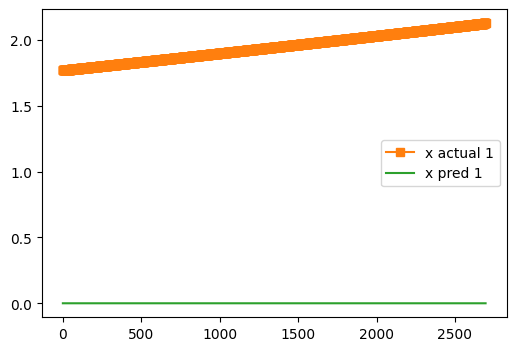

In [112]:
import matplotlib.pyplot as plt
func = 0
plt.figure(figsize=(6, 4))
plt.plot(y_test1[:,0], 's-',color='C1', label=f'x actual {func+1}')
plt.plot(preds_x[func], '-',color='C2', label=f'x pred {func+1}')

try:
    plt.plot(y_test1[:,1], 's-',color='C0', label=f'u actual {func+1}')
    plt.plot(preds_u[func], '-',color='C3', label=f'u pred {func+1}')
except:
    pass
plt.legend()

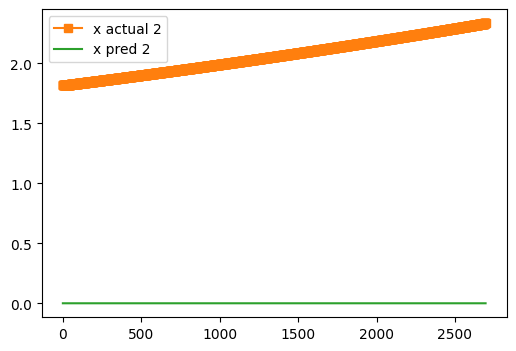

In [113]:
import matplotlib.pyplot as plt
func = 1
plt.figure(figsize=(6, 4))
plt.plot(y_test2[:,0], 's-',color='C1', label=f'x actual {func+1}')
plt.plot(preds_x[func], '-',color='C2', label=f'x pred {func+1}')

try:
    plt.plot(y_test2[:,1], 's-',color='C0', label=f'u actual {func+1}')
    plt.plot(preds_u[func], '-',color='C3', label=f'u pred {func+1}')
except:
    pass
plt.legend()

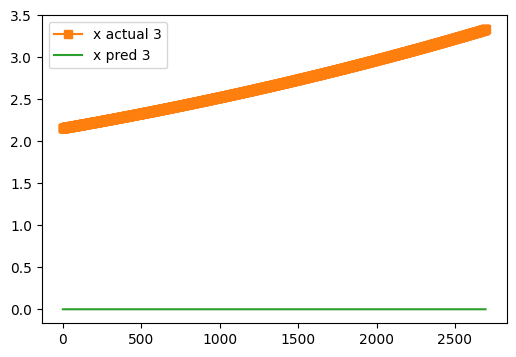

In [114]:
import matplotlib.pyplot as plt
func = 2
plt.figure(figsize=(6, 4))
plt.plot(y_test3[:,0], 's-',color='C1', label=f'x actual {func+1}')
plt.plot(preds_x[func], '-',color='C2', label=f'x pred {func+1}')

try:
    plt.plot(y_test3[:,1], 's-',color='C0', label=f'u actual {func+1}')
    plt.plot(preds_u[func], '-',color='C3', label=f'u pred {func+1}')
except:
    pass
plt.legend()